In [1]:
# If running first time, uncomment below
# !pip install tensorflow matplotlib numpy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

input_shape = (28, 28, 1)
latent_dim = 2

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [4]:
def build_encoder(input_shape, latent_dim):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Flatten input
    x = tf.keras.layers.Flatten()(inputs)

    # Fully connected layer
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    # Latent mean and log variance
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

    return tf.keras.Model(inputs, [z_mean, z_log_var], name="encoder")


In [5]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [6]:
def build_decoder(latent_dim):
    inputs = tf.keras.layers.Input(shape=(latent_dim,))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(28 * 28, activation='sigmoid')(x)

    outputs = tf.keras.layers.Reshape((28, 28, 1))(x)

    return tf.keras.Model(inputs, outputs, name="decoder")


In [7]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling((z_mean, z_log_var))
        reconstructed = self.decoder(z)

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(inputs, reconstructed),
                axis=(1, 2)
            )
        )

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )

        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)

        return reconstructed


In [9]:
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim)

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

vae(tf.zeros((1, 28, 28, 1))
    )
vae.summary()


Model: "vae_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               100996    
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         101520    
                                                                 
 sampling_1 (Sampling)       multiple                  0         
                                                                 
Total params: 202516 (791.08 KB)
Trainable params: 202516 (791.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
history = vae.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test, x_test)
)


Epoch 1/10

469/469 [==============================] - 3s 4ms/step - loss: 214.5690 - val_loss: 186.3848
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 181.6346 - val_loss: 175.8986
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 172.2573 - val_loss: 169.7616
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 168.2929 - val_loss: 167.5014
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 166.3775 - val_loss: 165.9782
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 165.0007 - val_loss: 164.7457
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 163.8787 - val_loss: 163.6614
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 162.8910 - val_loss: 162.8463
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 161.9605 - val_loss: 162.0234
Epoch 10/10
469/469 [==============================] - 2s 4ms/s

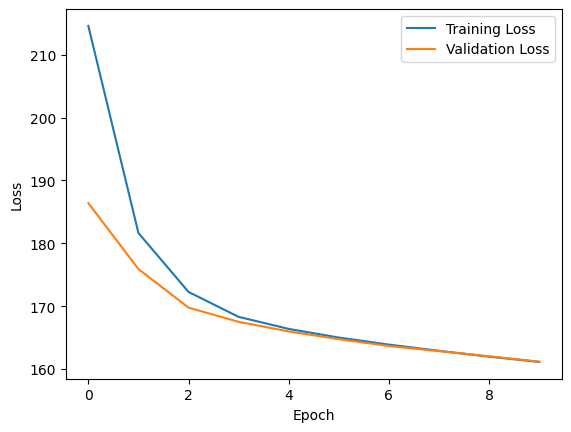

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


1/1 [==============================] - 0s 106ms/step


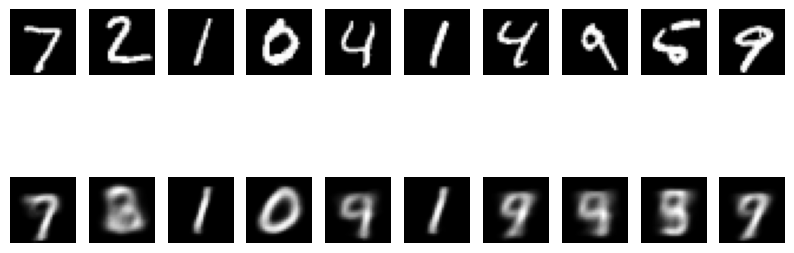

In [12]:
decoded_images = vae.predict(x_test[:10])

plt.figure(figsize=(10, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap="gray")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_images[i].squeeze(), cmap="gray")
    plt.axis("off")

plt.show()


1/1 [==============================] - 0s 42ms/step


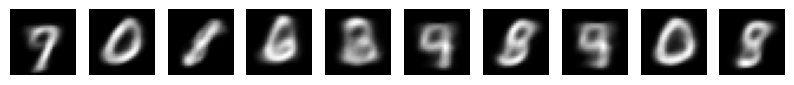

In [13]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap="gray")
    plt.axis("off")

plt.show()
